# Kaggle competiton: Titanic
By Junbo

## Project Discription
This project is for the Kaggle competition "Titanic: Machine Learning from Disaster" https://www.kaggle.com/c/titanic. The dataset is provided by Kaggle.  
The final goal of this competition is to accurately predict whether a passenger on Titanic will survive or not.

## Import packages

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler

import re

from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.svm import SVC

import warnings
warnings.filterwarnings('ignore')

# 1. Import dataset

In [2]:
train = pd.read_csv('tatinic/train.csv')
test = pd.read_csv('tatinic/test.csv')

In [3]:
(train.shape,test.shape)

((891, 12), (418, 11))

In [4]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [5]:
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [6]:
test['Survived'] = np.nan
test.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Survived
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q,NaN
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S,NaN
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q,NaN
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S,NaN
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S,NaN


In [7]:
combin = train.append(test)

In [8]:
combin.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1309 entries, 0 to 417
Data columns (total 12 columns):
Age            1046 non-null float64
Cabin          295 non-null object
Embarked       1307 non-null object
Fare           1308 non-null float64
Name           1309 non-null object
Parch          1309 non-null int64
PassengerId    1309 non-null int64
Pclass         1309 non-null int64
Sex            1309 non-null object
SibSp          1309 non-null int64
Survived       891 non-null float64
Ticket         1309 non-null object
dtypes: float64(3), int64(4), object(5)
memory usage: 132.9+ KB


# 2 Feature engineering
Clean data, fill missing data, creat new features, encode features

## 2.1 Cabin

In [9]:
le = LabelEncoder()

The missing cabin number may reflect some info

In [10]:
combin['Cabin'] = combin['Cabin'].fillna('U')

In [11]:
combin['Cabin_Capital'] = combin['Cabin'].apply(lambda x:x[0])

In [12]:
le.fit(['U', 'C', 'E', 'G', 'D', 'A', 'B', 'F', 'T'])

LabelEncoder()

In [13]:
le.transform(['U', 'C', 'E', 'G', 'D', 'A', 'B', 'F', 'T'])

array([8, 2, 4, 6, 3, 0, 1, 5, 7], dtype=int64)

In [14]:
combin['Cabin_Capital'] = le.transform(combin['Cabin_Capital'])

In [15]:
combin['Has_Cabin'] = combin['Cabin'].apply(lambda x: 0 if x == 'U' else 1)

## 2.2 Embarked

Use the mode to fill missing values in Embarked

In [16]:
combin['Embarked'] = combin['Embarked'].fillna(combin['Embarked'].mode()[0])

In [17]:
combin['Embarked'].mode()[0]

'S'

In [18]:
combin['Embarked'].unique()

array(['S', 'C', 'Q'], dtype=object)

In [19]:
le.fit_transform(['S', 'C', 'Q'])

array([2, 0, 1], dtype=int64)

In [20]:
combin['Embarked'] = le.transform(combin['Embarked'])

## 2.3 Fare

Check missing value in Fare

In [21]:
combin[combin['Fare'].isnull()]

,Age,Cabin,Embarked,Fare,Name,Parch,PassengerId,Pclass,Sex,SibSp,Survived,Ticket,Cabin_Capital,Has_Cabin
152,60.5,U,2,NaN,"Storey, Mr. Thomas",0,1044,3,male,0,NaN,3701,8,0


Fill the missing value using the mean value of fares in the similiar groups

In [22]:
combin[(combin['Pclass']==3) & (combin['Cabin'] =='U') & (combin['Sex'] =='male')]['Fare'].median()

7.8958

In [23]:
combin.loc[combin['Fare'].isnull(),'Fare'] = 7.8958

## 2.4 Name

Extract titles

In [24]:
combin['Title'] = combin['Name'].map(lambda x: re.compile(", (.*?)\.").findall(x)[0])

In [25]:
combin['Title'].unique()

array(['Mr', 'Mrs', 'Miss', 'Master', 'Don', 'Rev', 'Dr', 'Mme', 'Ms',
       'Major', 'Lady', 'Sir', 'Mlle', 'Col', 'Capt', 'the Countess',
       'Jonkheer', 'Dona'], dtype=object)

Claissify people based on their titles

In [26]:
Title_Dictionary = {
    "Capt": "Officer",
    "Col": "Officer",
    "Major": "Officer",
    "Jonkheer": "Royalty",
    "Don": "Royalty",
    "Dona": "Royalty",
    "Sir" : "Royalty",
    "Dr": "Officer",
    "Rev": "Officer",
    "the Countess":"Royalty",
    "Mme": "Mrs",
    "Mlle": "Miss",
    "Ms": "Mrs",
    "Mr" : "Mr",
    "Mrs" : "Mrs",
    "Miss" : "Miss",
    "Master" : "Master",
    "Lady" : "Royalty"
}

In [27]:
combin['Title'] = combin['Title'].map(Title_Dictionary)

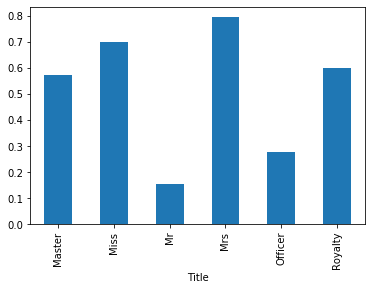

In [28]:
combin.groupby(['Title'])['Survived'].mean().plot.bar()

In [29]:
combin['Title'].unique()

array(['Mr', 'Mrs', 'Miss', 'Master', 'Royalty', 'Officer'], dtype=object)

In [30]:
le.fit_transform(['Mr', 'Mrs', 'Miss', 'Master', 'Royalty', 'Officer'])

array([2, 3, 1, 0, 5, 4], dtype=int64)

In [31]:
combin['Title'] = le.transform(combin['Title'])

Could distinguish between officers and royalty nembers. Also, could divide females into married and not marrried(not done here)

In [32]:
combin['Is_Royalty'] = combin['Title'].apply(lambda x: 1 if x == 5 else 0)
combin['Is_Officer'] = combin['Title'].apply(lambda x: 1 if x == 4 else 0)

Last names(not done here)

In [33]:
# combin['Last_Name'] = combin['Name'].map(lambda x: re.compile("([a-zA-Z]+)\,").findall(x)[0])

Name length

In [34]:
combin['Name_length'] = combin['Name'].apply(len)

## 2.5 Parch and SibSp

Total family size

In [35]:
combin['Family_Size'] = 1 + combin['Parch'] + combin['SibSp']

Classify people based on the total family size

In [36]:
def family_size_category(family_size):
    if family_size == 1:
        return 'Single'
    elif family_size <= 4:
        return 'Small_Family'
    else:
        return 'Large_Family'

In [37]:
combin['Family_Size_Category'] = combin['Family_Size'].apply(family_size_category)

In [38]:
combin['Family_Size_Category'].unique()

array(['Small_Family', 'Single', 'Large_Family'], dtype=object)

In [39]:
le.fit_transform(['Small_Family', 'Single', 'Large_Family'])

array([2, 1, 0], dtype=int64)

In [40]:
combin['Family_Size_Category'] = le.transform(combin['Family_Size_Category'])

Is single or not

In [41]:
combin['Is_single'] = combin['Family_Size'].apply(lambda x: 1 if x == 1 else 0)

## 2.6 Pclass

In [42]:
combin['Pclass'].unique()

array([3, 1, 2], dtype=int64)

## 2.7 Sex

In [43]:
combin['Sex'].unique()

array(['male', 'female'], dtype=object)

In [44]:
le.fit_transform(['male', 'female'])

array([1, 0], dtype=int64)

In [45]:
combin['Sex'] = le.transform(combin['Sex'])

## 2.8 Ticket

In [46]:
def find_all_number(number):
    x = re.findall(r'\d+',number)
    if len(x) == 0:
        return 0
    else:
        return int(x[-1])
    
combin['Ticket_number'] = combin['Ticket'].apply(find_all_number)

Count the number of group members based on the number of same tickets

In [47]:
combin['Group_Ticket'] = combin.groupby('Ticket_number')['Cabin'].transform('count')

Wether the person has the ticket number? (Excluded due to no effect on survival)

In [48]:
# combin['Has_ticket_letter'] = combin['Ticket_letter'].apply(lambda x: 0 if x == 'None' else 1)

Classify based on letters at the beginning of each ticket

In [49]:
combin['Ticket_letter'] = combin['Ticket'].str.split().str[0]
combin['Ticket_letter'] = combin['Ticket_letter'].apply(lambda x: 'None' if x.isnumeric() else x)

In [50]:
def process_letter(x):
    x = x.replace('.','')
    x = x.replace('/','')
    return x

In [51]:
combin['Ticket_letter'] = combin['Ticket_letter'].apply(process_letter)
combin['Ticket_letter'].unique()

array(['A5', 'PC', 'STONO2', 'None', 'PP', 'CA', 'SCParis', 'SCA4', 'A4',
       'SP', 'SOC', 'WC', 'SOTONOQ', 'WEP', 'STONO', 'C', 'SCPARIS',
       'SOP', 'Fa', 'LINE', 'FCC', 'SWPP', 'SCOW', 'PPP', 'SC', 'SCAH',
       'AS', 'SOPP', 'FC', 'SOTONO2', 'CASOTON', 'SCA3', 'STONOQ', 'AQ4',
       'A', 'LP', 'AQ3'], dtype=object)

In [52]:
le.fit_transform(['A5', 'PC', 'STONO2', 'None', 'PP', 'CA', 'SCParis', 'SCA4', 'A4',
       'SP', 'SOC', 'WC', 'SOTONOQ', 'WEP', 'STONO', 'C', 'SCPARIS',
       'SOP', 'Fa', 'LINE', 'FCC', 'SWPP', 'SCOW', 'PPP', 'SC', 'SCAH',
       'AS', 'SOPP', 'FC', 'SOTONO2', 'CASOTON', 'SCA3', 'STONOQ', 'AQ4',
       'A', 'LP', 'AQ3'])

array([ 2, 15, 32, 14, 16,  7, 24, 20,  1, 30, 25, 35, 29, 36, 31,  6, 23,
       26, 11, 12, 10, 34, 22, 17, 18, 21,  5, 27,  9, 28,  8, 19, 33,  4,
        0, 13,  3], dtype=int64)

In [53]:
combin['Ticket_letter'] = le.transform(combin['Ticket_letter'])

### 2.8.1 Interactions between tickets and other features
exclude the impact of group tickets, so that fares are only affected by classes, not by sizes of groups

In [54]:
combin['Fare'] = combin['Fare']/combin['Group_Ticket']

In [55]:
combin.groupby(['Pclass','Group_Ticket'])['Fare'].mean()

Pclass  Group_Ticket
1       1               29.192513
        2               32.091612
        3               34.599215
        4               49.072787
        5               38.235000
        6               34.545833
        7               37.482143
2       1               12.201304
        2               11.625547
        3                8.929595
        4                9.067450
        5               13.000000
        7               10.500000
3       1                7.892832
        2                7.193291
        3                6.215207
        4                4.013905
        5                5.394447
        6                4.752083
        7                4.873810
        8                6.462238
        11               6.322727
Name: Fare, dtype: float64

Exclude those who are in groups but are misclassified as single  
*Note: single means that a person was traveling without mates, not without families*

In [56]:
combin.loc[(combin['Is_single']==1)&(combin['Group_Ticket']!=1),'Is_single'] = 0

Found out that family size and number of group members are incompatible. Let models to deal with the problem

In [57]:
combin.loc[combin['Family_Size']!= combin['Group_Ticket']]

,Age,Cabin,Embarked,Fare,Name,Parch,PassengerId,Pclass,Sex,SibSp,...,Title,Is_Royalty,Is_Officer,Name_length,Family_Size,Family_Size_Category,Is_single,Ticket_number,Group_Ticket,Ticket_letter
0,22.0,U,2,7.250000,"Braund, Mr. Owen Harris",0,1,3,1,1,...,2,0,0,23,2,2,0,21171,1,2
6,54.0,E46,2,25.931250,"McCarthy, Mr. Timothy J",0,7,1,1,0,...,2,0,0,23,1,1,0,17463,2,14
20,35.0,U,2,13.000000,"Fynney, Mr. Joseph J",0,21,2,1,0,...,2,0,0,20,1,1,0,239865,2,14
31,NaN,B78,0,48.840267,"Spencer, Mrs. William Augustus (Marie Eugenie)",0,32,1,0,1,...,3,0,0,46,2,2,0,17569,3,15
38,18.0,U,2,9.000000,"Vander Planke, Miss. Augusta Maria",0,39,3,0,2,...,1,0,0,34,3,2,0,345764,2,14
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
404,43.0,D40,0,27.720800,"Frauenthal, Mr. Isaac Gerald",0,1296,1,1,1,...,2,0,0,28,2,2,0,17765,1,14
406,23.0,U,2,10.500000,"Ware, Mr. William Jeffery",0,1298,2,1,1,...,2,0,0,25,2,2,0,28666,1,14
407,50.0,C80,0,42.300000,"Widener, Mr. George Dunton",1,1299,1,1,1,...,2,0,0,26,3,2,0,113503,5,14
411,37.0,C78,1,30.000000,"Minahan, Mrs. William Edward (Lillian E Thorpe)",0,1303,1,0,1,...,3,0,0,47,2,2,0,19928,3,14


## 2.9 Age

In [58]:
combin.columns

Index(['Age', 'Cabin', 'Embarked', 'Fare', 'Name', 'Parch', 'PassengerId',
       'Pclass', 'Sex', 'SibSp', 'Survived', 'Ticket', 'Cabin_Capital',
       'Has_Cabin', 'Title', 'Is_Royalty', 'Is_Officer', 'Name_length',
       'Family_Size', 'Family_Size_Category', 'Is_single', 'Ticket_number',
       'Group_Ticket', 'Ticket_letter'],
      dtype='object')

Classify people into 4 groups

In [59]:
def age_classification(x):
    if x <= 18:
        return 1
    elif x <= 40:
        return 2
    elif x <= 60:
        return 3
    elif x > 60:
        return 4
    else:
        return np.nan

In [60]:
combin['Age_classification'] = combin['Age'].apply(age_classification)

### 2.9.1 Build a model to fill missing values in age classifications
Based on features above

In [61]:
feature_age = ['Embarked', 'Fare', 'Parch', 
       'Pclass', 'Sex', 'SibSp', 'Cabin_Capital',
       'Has_Cabin', 'Title', 'Family_Size',
       'Family_Size_Category', 'Is_single', 'Ticket_number', 'Group_Ticket']
age_train_X = combin[feature_age][combin['Age'].notnull()]
age_train_y = combin['Age_classification'][combin['Age'].notnull()]
age_predict_X = combin[feature_age][combin['Age'].isnull()]

In [62]:
rf_age = RandomForestClassifier(random_state=0)
rf_age_param_grid = {'n_estimators':[200,300,400],'max_depth':[7,8,9]}
rf_age_gridsearch = GridSearchCV(rf_age,param_grid=rf_age_param_grid, cv=10, scoring='accuracy')
rf_age_gridsearch.fit(age_train_X,age_train_y)

GridSearchCV(cv=10, error_score='raise-deprecating',
             estimator=RandomForestClassifier(bootstrap=True, class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators='warn', n_jobs=None,
                                              oob_score=False, random_state=0,
                                              verbose=0, warm_start=False),
             iid='warn', n_jobs=None,
             param_grid={'

In [63]:
age_pred = rf_age_gridsearch.predict(age_predict_X)

In [64]:
combin['Age_classification'][combin['Age'].isnull()] = age_pred

Check wether there are other missing values in the dataset

In [65]:
combin.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1309 entries, 0 to 417
Data columns (total 25 columns):
Age                     1046 non-null float64
Cabin                   1309 non-null object
Embarked                1309 non-null int32
Fare                    1309 non-null float64
Name                    1309 non-null object
Parch                   1309 non-null int64
PassengerId             1309 non-null int64
Pclass                  1309 non-null int64
Sex                     1309 non-null int32
SibSp                   1309 non-null int64
Survived                891 non-null float64
Ticket                  1309 non-null object
Cabin_Capital           1309 non-null int32
Has_Cabin               1309 non-null int64
Title                   1309 non-null int32
Is_Royalty              1309 non-null int64
Is_Officer              1309 non-null int64
Name_length             1309 non-null int64
Family_Size             1309 non-null int64
Family_Size_Category    1309 non-null int32
Is_sin

### 2.9.2 Distinguish children

In [66]:
combin['Is_children'] = combin['Age_classification'].apply(lambda x: 1 if x == 1 else 0)

### 2.9.3 Interactions between age and sex

In [67]:
combin['Male_adult'] = 0
combin.loc[(combin['Is_children']==0)&(combin['Sex']==1),'Male_adult'] = 1

In [68]:
combin['Female_adult'] = 0
combin.loc[(combin['Is_children']==0)&(combin['Sex']==0),'Female_adult'] = 1

### 2.9.4 In each family/group, whether there are dead children/females or survived males?

In [69]:
ticket_df = pd.DataFrame(combin['Ticket_number'].value_counts())
ticket_df['family_with_dead_children_women'] = combin.Ticket_number[((combin.Is_children == 1)|(combin.Female_adult == 1)) & (combin.Survived == 0) & (combin.Is_single == 0)].value_counts()
ticket_df['family_with_dead_children_women'] = ticket_df['family_with_dead_children_women'].apply(lambda x: 1 if x > 0 else 0)

ticket_df['family_with_surviving_man'] = combin.Ticket_number[(combin.Male_adult == 1) & (combin.Survived == 1) & (combin.Is_single == 0)].value_counts()
ticket_df['family_with_surviving_man'] = ticket_df['family_with_surviving_man'].apply(lambda x: 1 if x > 0 else 0)

ticket_df.drop(['Ticket_number'],axis=1, inplace=True)

combin = pd.merge(combin,ticket_df,left_on='Ticket_number',right_index=True,how='left',sort=False)

## 2.10 Dataset after feature extraction

In [70]:
combin.head()

,Age,Cabin,Embarked,Fare,Name,Parch,PassengerId,Pclass,Sex,SibSp,...,Is_single,Ticket_number,Group_Ticket,Ticket_letter,Age_classification,Is_children,Male_adult,Female_adult,family_with_dead_children_women,family_with_surviving_man
0,22.0,U,2,7.25000,"Braund, Mr. Owen Harris",0,1,3,1,1,...,0,21171,1,2,2.0,0,1,0,0,0
1,38.0,C85,0,35.64165,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,2,1,0,1,...,0,17599,2,15,2.0,0,0,1,0,0
2,26.0,U,2,7.92500,"Heikkinen, Miss. Laina",0,3,3,0,0,...,1,3101282,1,32,2.0,0,0,1,0,0
3,35.0,C123,2,26.55000,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",0,4,1,0,1,...,0,113803,2,14,2.0,0,0,1,0,0
4,35.0,U,2,8.05000,"Allen, Mr. William Henry",0,5,3,1,0,...,1,373450,1,14,2.0,0,1,0,0,0


In [71]:
combin.columns

Index(['Age', 'Cabin', 'Embarked', 'Fare', 'Name', 'Parch', 'PassengerId',
       'Pclass', 'Sex', 'SibSp', 'Survived', 'Ticket', 'Cabin_Capital',
       'Has_Cabin', 'Title', 'Is_Royalty', 'Is_Officer', 'Name_length',
       'Family_Size', 'Family_Size_Category', 'Is_single', 'Ticket_number',
       'Group_Ticket', 'Ticket_letter', 'Age_classification', 'Is_children',
       'Male_adult', 'Female_adult', 'family_with_dead_children_women',
       'family_with_surviving_man'],
      dtype='object')

## 2.11 Standardize continuous features

In [72]:
continuous_features = ['Fare','SibSp','Name_length','Family_Size','Group_Ticket']
stdscaler = StandardScaler()
combin[continuous_features] = stdscaler.fit_transform(combin[continuous_features])

# 3 Build models

## 3.1 Choose features and check correlation coefficient

In [73]:
features = ['Embarked', 'Fare','Parch',
       'Pclass', 'Sex', 'SibSp', 'Cabin_Capital',
       'Has_Cabin', 'Title', 'Name_length', 'Family_Size',
       'Family_Size_Category', 'Is_single', 'Group_Ticket',
       'Age_classification', 'Is_children', 'Male_adult', 'Female_adult',
       'family_with_dead_children_women', 'family_with_surviving_man',
       'Ticket_letter']

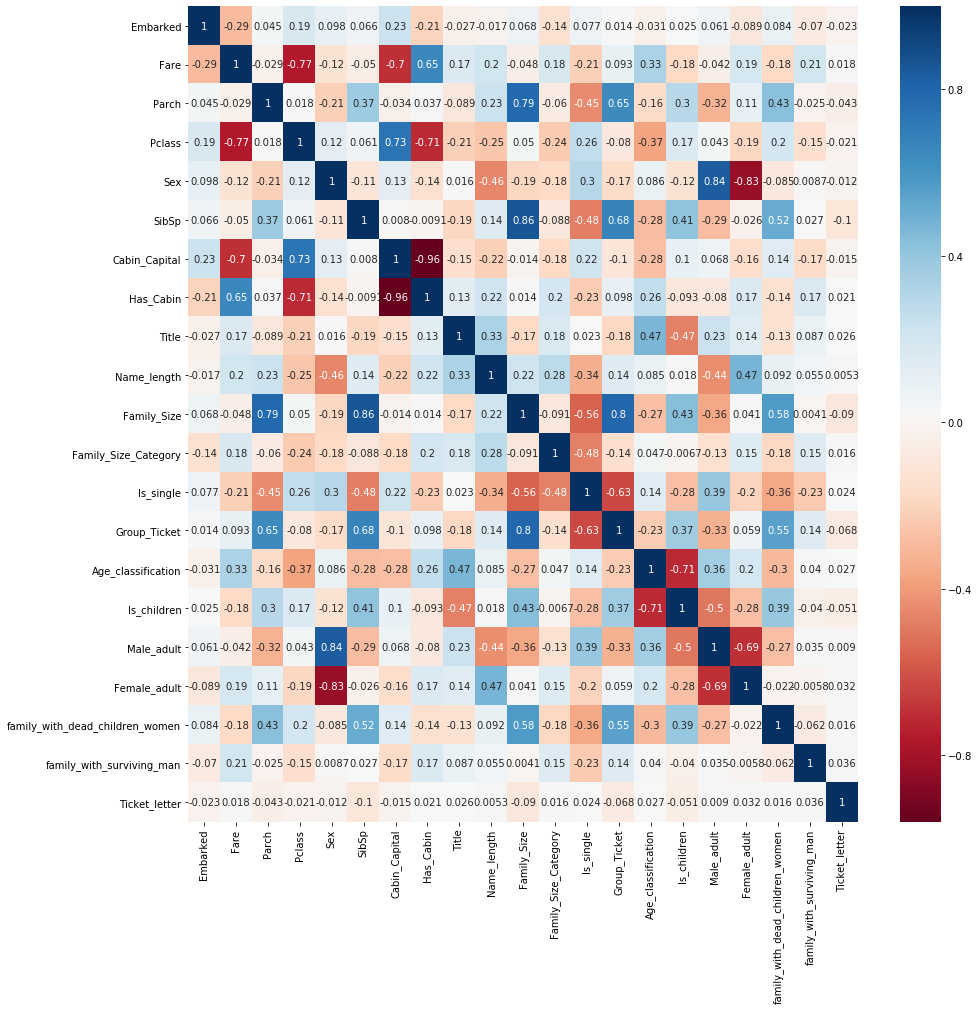

In [74]:
plt.figure(figsize=(15,15))
sns.heatmap(combin[features].corr(),cmap=plt.cm.RdBu,annot=True)

## 3.2 Split train & test set

In [75]:
train_X = combin.loc[combin['Survived'] >= 0,features]
train_y = combin.loc[combin['Survived'] >= 0,'Survived']
test_X = combin.loc[combin['Survived'].isnull(),features]

## 3.3 Build models

### a. Random Forest

In [76]:
rf = RandomForestClassifier(random_state=0)
rf_param_grid = {'n_estimators':[300,600,1000],'max_depth':[6,7,8],'min_samples_split':[5,6,7]}
rf_gridsearch= GridSearchCV(rf, param_grid=rf_param_grid, cv = 10, scoring='accuracy', n_jobs=-1)
rf_gridsearch.fit(train_X,train_y)

GridSearchCV(cv=10, error_score='raise-deprecating',
             estimator=RandomForestClassifier(bootstrap=True, class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators='warn', n_jobs=None,
                                              oob_score=False, random_state=0,
                                              verbose=0, warm_start=False),
             iid='warn', n_jobs=-1,
             param_grid={'ma

In [77]:
rf_gridsearch.best_score_

0.9001122334455668

In [78]:
rf_gridsearch.best_params_

{'max_depth': 8, 'min_samples_split': 7, 'n_estimators': 300}

In [79]:
rf_gridsearch.cv_results_

{'mean_fit_time': array([0.43723052, 0.83337092, 1.46927018, 0.47183821, 0.98187401,
        1.45849905, 0.44780192, 0.92193389, 1.42139828, 0.44740322,
        0.9394865 , 1.51335218, 0.44381278, 0.88812454, 1.48293366,
        0.45248959, 0.9026854 , 1.51175663, 0.48609982, 0.92492685,
        1.52192938, 0.45318763, 0.90388241, 1.50667055, 0.45837359,
        0.91196089, 1.40026267]),
 'std_fit_time': array([0.01228966, 0.02076336, 0.14785334, 0.04374322, 0.15393993,
        0.05014146, 0.0290189 , 0.04403512, 0.02564834, 0.01607011,
        0.02498096, 0.03141567, 0.0061962 , 0.02656812, 0.01424116,
        0.01520454, 0.02154535, 0.03142372, 0.02265993, 0.02111153,
        0.01432875, 0.00522453, 0.0131257 , 0.01762775, 0.01197775,
        0.01260891, 0.17606175]),
 'mean_score_time': array([0.03311107, 0.05864296, 0.10501926, 0.03620315, 0.07091088,
        0.11190114, 0.03251317, 0.0654253 , 0.11239951, 0.03251307,
        0.06592374, 0.10571759, 0.03371058, 0.06552486, 0.108908

In [80]:
# feature importances
pd.DataFrame(rf_gridsearch.best_estimator_.feature_importances_,index=features).sort_values(0)

,0
Parch,0.009001
Is_children,0.009842
Embarked,0.011768
SibSp,0.012636
Is_single,0.013136
Age_classification,0.016938
Ticket_letter,0.018413
Has_Cabin,0.023629
Family_Size,0.023941
Family_Size_Category,0.027234


### B. GBDT

In [81]:
gbdt = GradientBoostingClassifier(random_state=0,verbose=1)
gbdt_param_grid = {'n_estimators':[300,1000,600],'max_depth':[6,7,8,10],'learning_rate':[0.1,0.01],'max_leaf_nodes':[15,25,35,45]}
gbdt_gridsearch = GridSearchCV(gbdt,gbdt_param_grid,cv = 10, n_jobs = -1)
gbdt_gridsearch.fit(train_X,train_y)

      Iter       Train Loss   Remaining Time 
         1           1.3176            0.91s
         2           1.3038            0.74s
         3           1.2902            0.69s
         4           1.2769            0.66s
         5           1.2639            0.71s
         6           1.2512            0.68s
         7           1.2387            0.67s
         8           1.2265            0.66s
         9           1.2146            0.64s
        10           1.2029            0.64s
        20           1.0974            0.59s
        30           1.0094            0.56s
        40           0.9349            0.53s
        50           0.8712            0.51s
        60           0.8167            0.50s
        70           0.7697            0.48s
        80           0.7284            0.46s
        90           0.6924            0.44s
       100           0.6608            0.41s
       200           0.4863            0.20s
       300           0.3957            0.00s


GridSearchCV(cv=10, error_score='raise-deprecating',
             estimator=GradientBoostingClassifier(criterion='friedman_mse',
                                                  init=None, learning_rate=0.1,
                                                  loss='deviance', max_depth=3,
                                                  max_features=None,
                                                  max_leaf_nodes=None,
                                                  min_impurity_decrease=0.0,
                                                  min_impurity_split=None,
                                                  min_samples_leaf=1,
                                                  min_samples_split=2,
                                                  min_weight_fraction_leaf=0.0,
                                                  n_estimators=100,
                                                  n_iter_no_change=None,
                                                  presort

In [82]:
gbdt_gridsearch.best_score_

0.8933782267115601

In [83]:
gbdt_gridsearch.best_params_

{'learning_rate': 0.01,
 'max_depth': 10,
 'max_leaf_nodes': 15,
 'n_estimators': 300}

In [84]:
pd.DataFrame(gbdt_gridsearch.best_estimator_.feature_importances_,index=features).sort_values(0)

,0
Female_adult,0.000492
Parch,0.000857
Has_Cabin,0.001098
Is_children,0.001522
Group_Ticket,0.001666
Male_adult,0.003961
Embarked,0.008524
Ticket_letter,0.009275
Age_classification,0.010485
Cabin_Capital,0.011688


### C. SVM

In [85]:
svc = SVC(random_state = 0)
svc_param_grid ={'C':[0.1,1,10,100,0.01],'gamma':[0.1,1,10,100,0.01]}
svc_gridsearch = GridSearchCV(svc,param_grid = svc_param_grid, cv = 10, n_jobs=-1)
svc_gridsearch.fit(train_X,train_y)

GridSearchCV(cv=10, error_score='raise-deprecating',
             estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
                           decision_function_shape='ovr', degree=3,
                           gamma='auto_deprecated', kernel='rbf', max_iter=-1,
                           probability=False, random_state=0, shrinking=True,
                           tol=0.001, verbose=False),
             iid='warn', n_jobs=-1,
             param_grid={'C': [0.1, 1, 10, 100, 0.01],
                         'gamma': [0.1, 1, 10, 100, 0.01]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=0)

In [86]:
svc_gridsearch.best_score_

0.8855218855218855

In [87]:
svc_gridsearch.best_params_

{'C': 10, 'gamma': 0.01}

# 4 Model ensemble
Using average voting

In [88]:
prediction = pd.DataFrame([rf_gridsearch.predict(test_X),gbdt_gridsearch.predict(test_X),svc_gridsearch.predict(test_X)]).T
prediction.columns=['rf','gbdt','svc']
prediction['pred'] = prediction[['rf','gbdt','svc']].mode(axis=1).astype(int)

In [89]:
passenger_id = pd.read_csv('tatinic/test.csv')['PassengerId']
submission = pd.DataFrame({'PassengerId':passenger_id,'Survived':prediction['pred']})
submission

,PassengerId,Survived
0,892,0
1,893,1
2,894,0
3,895,0
4,896,1
...,...,...
413,1305,0
414,1306,0
415,1307,0
416,1308,0


**Final result:**  
Score(Accuracy): 0.80861  
Ranking: 773/16066 (Top 5%)